In [48]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
import warnings
warnings.filterwarnings('ignore')

In [50]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [51]:
sns.set_style('whitegrid')
np.random.seed(42)

# Get Data

# Things to do
## Test other CC
## Construct Strategy

In [52]:
df=pd.read_csv('CC_daily_data.csv').dropna()
dfclose = df[df['ticker']=='BTC-USD'].set_index(['date'])['close'].to_frame()
dfclose = dfclose[~dfclose.index.duplicated(keep = 'first')]
dfclose

,close
date,
2017-01-01,998.325012
2017-01-02,1021.750000
2017-01-03,1043.839966
2017-01-04,1154.729980
2017-01-05,1013.380005
...,...
2020-12-26,26437.037109
2020-12-27,26272.294922
2020-12-28,27084.808594


In [53]:
dfreturn = (np.log(dfclose/dfclose.shift())
            .dropna()
            .rename(columns = {'close':'return'}))
dfreturn

,return
date,
2017-01-02,0.023193
2017-01-03,0.021389
2017-01-04,0.100960
2017-01-05,-0.130575
2017-01-06,-0.116209
...,...
2020-12-26,0.069389
2020-12-27,-0.006251
2020-12-28,0.030458


In [54]:
results_path = Path('results', 'univariate_LSTM')
if not results_path.exists():
    results_path.mkdir(parents=True)

# Predicting Future Price:

# Preprocessing

In [55]:
scaler = MinMaxScaler()
dfclose_scaled = pd.Series(scaler.fit_transform(dfclose).squeeze(),index =dfclose.index)
dfclose_scaled.describe()

count    1452.000000
mean        0.239884
std         0.151313
min         0.000000
25%         0.119057
50%         0.235580
75%         0.316636
max         1.000000
dtype: float64

# Generating recurrent sequences from the time series

We will generate sequences of 90 trading days, approximately 3 months, and use a single LSTM layer with 10 hidden units to predict the index value one timestep ahead. 
The input to every LSTM layer must have three dimensions, namely:
- **Samples**: One sequence is one sample. A batch contains one or more samples.
- **Time Steps**: One time step is one point of observation in the sample.
- **Features**: One feature is one observation at a time step.

In [56]:
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y


In [57]:
window_size = 90

In [58]:
X,y = create_univariate_rnn_data(dfclose_scaled, window_size)

In [59]:
X.shape

(1362, 90)

# Train-test split

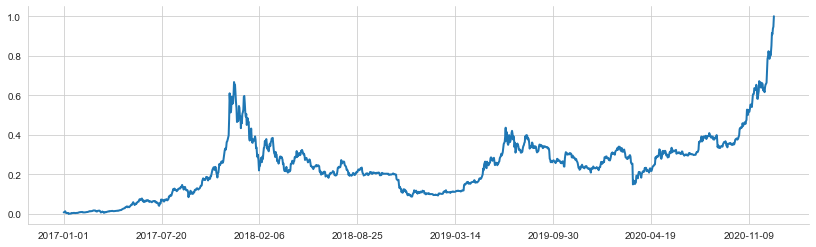

In [60]:
ax = dfclose_scaled.plot(lw=2, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [61]:
X_train = X[:'2020'].values.reshape(-1, window_size, 1)
y_train = y[:'2020']

# keep the last year for testing
X_test = X['2020':].values.reshape(-1, window_size, 1)
y_test = y['2020':]

In [62]:
n_obs, window_size, n_features = X_train.shape

In [63]:
y_train.shape

(1002,)

# Define Model Architechture

In [64]:
rnn_price = Sequential([
    LSTM(units = 10, input_shape = (window_size,n_features), name='LSTM'),
    Dense(1, name='Output')
])

In [65]:
rnn_price.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (None, 10)                480       
_________________________________________________________________
Output (Dense)               (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


# Train the Model

In [66]:
optimizer = keras.optimizers.RMSprop(lr=.001, rho = .9, epsilon = 1e-08, decay = .0)
rnn_price.compile(loss = 'mean_squared_error', optimizer = optimizer)

In [67]:
rnn_path = (results_path / 'rnn.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=rnn_path,verbose=1,monitor='val_loss',save_best_only=True)

In [68]:
early_stopping = EarlyStopping(monitor = 'val_loss',patience = 20, restore_best_weights = True)

In [69]:
lstm_training_price = rnn_price.fit(X_train,y_train, epochs = 150, batch_size = 20, shuffle = True, validation_data=(X_test,y_test),callbacks = [early_stopping,checkpointer],verbose =1)

Epoch 1/150
51/51 [==============================] - 3s 18ms/step - loss: 0.0256 - val_loss: 0.0092

Epoch 00001: val_loss improved from inf to 0.00922, saving model to results/univariate_LSTM\rnn.h5
Epoch 2/150
51/51 [==============================] - 1s 10ms/step - loss: 0.0024 - val_loss: 0.0024

Epoch 00002: val_loss improved from 0.00922 to 0.00238, saving model to results/univariate_LSTM\rnn.h5
Epoch 3/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 0.0032

Epoch 00003: val_loss did not improve from 0.00238
Epoch 4/150
51/51 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 0.0077

Epoch 00004: val_loss did not improve from 0.00238
Epoch 5/150
51/51 [==============================] - 1s 10ms/step - loss: 0.0015 - val_loss: 0.0018

Epoch 00005: val_loss improved from 0.00238 to 0.00179, saving model to results/univariate_LSTM\rnn.h5
Epoch 6/150
51/51 [==============================] - 1s 10ms/step - loss: 0.0013 - val_l

51/51 [==============================] - 1s 11ms/step - loss: 2.8324e-04 - val_loss: 5.3583e-04

Epoch 00047: val_loss did not improve from 0.00041
Epoch 48/150
51/51 [==============================] - 1s 11ms/step - loss: 2.6682e-04 - val_loss: 0.0030

Epoch 00048: val_loss did not improve from 0.00041
Epoch 49/150
51/51 [==============================] - 1s 10ms/step - loss: 3.6253e-04 - val_loss: 5.0163e-04

Epoch 00049: val_loss did not improve from 0.00041
Epoch 50/150
51/51 [==============================] - 1s 10ms/step - loss: 2.8429e-04 - val_loss: 6.7201e-04

Epoch 00050: val_loss did not improve from 0.00041
Epoch 51/150
51/51 [==============================] - 1s 10ms/step - loss: 4.1066e-04 - val_loss: 4.8847e-04

Epoch 00051: val_loss did not improve from 0.00041
Epoch 52/150
51/51 [==============================] - 1s 10ms/step - loss: 2.8181e-04 - val_loss: 5.3143e-04

Epoch 00052: val_loss did not improve from 0.00041
Epoch 53/150
51/51 [==============================]

51/51 [==============================] - 1s 10ms/step - loss: 1.9692e-04 - val_loss: 4.5140e-04

Epoch 00097: val_loss did not improve from 0.00029
Epoch 98/150
51/51 [==============================] - 1s 10ms/step - loss: 2.1606e-04 - val_loss: 4.9312e-04

Epoch 00098: val_loss did not improve from 0.00029
Epoch 99/150
51/51 [==============================] - 1s 10ms/step - loss: 3.0092e-04 - val_loss: 4.1428e-04

Epoch 00099: val_loss did not improve from 0.00029
Epoch 100/150
51/51 [==============================] - 1s 10ms/step - loss: 2.0903e-04 - val_loss: 3.1305e-04

Epoch 00100: val_loss did not improve from 0.00029
Epoch 101/150
51/51 [==============================] - 1s 10ms/step - loss: 2.1406e-04 - val_loss: 3.0478e-04

Epoch 00101: val_loss did not improve from 0.00029
Epoch 102/150
51/51 [==============================] - 1s 10ms/step - loss: 2.3269e-04 - val_loss: 3.9799e-04

Epoch 00102: val_loss did not improve from 0.00029
Epoch 103/150
51/51 [=======================

# Evaluate model performance

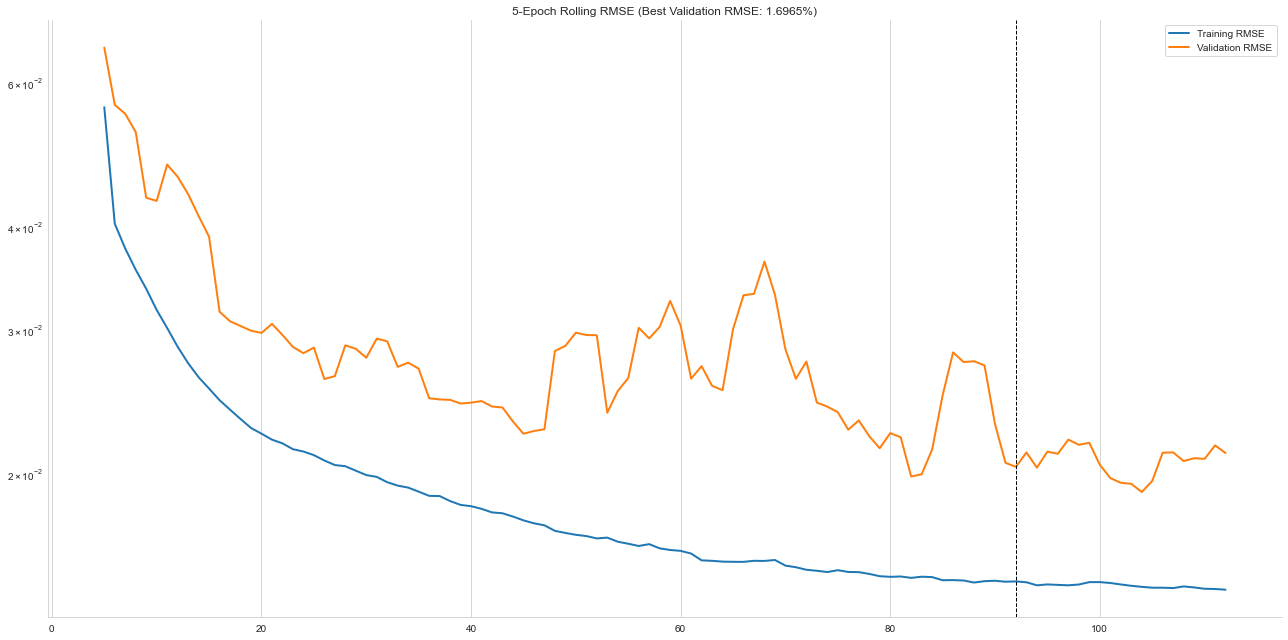

In [70]:
fig, ax = plt.subplots(figsize=(18, 9))

loss_history = pd.DataFrame(lstm_training_price.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_cc_error', dpi=300);

In [71]:
train_rmse_scaled = np.sqrt(rnn_price.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn_price.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

Train RMSE: 0.0149 | Test RMSE: 0.0170


In [72]:
train_predict_scaled = rnn_price.predict(X_train)
test_predict_scaled = rnn_price.predict(X_test)

In [73]:
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

Train IC: 0.9945 | Test IC: 0.9874


# Rescale predictions

In [74]:
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict =  pd.Series(scaler.inverse_transform(test_predict_scaled) .squeeze(), index=y_test.index)

In [75]:
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

In [76]:
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
print(f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}')

Train RMSE: 417.30 | Test RMSE: 476.10


In [77]:
dfclose['Train Predictions'] = train_predict
dfclose['Test Predictions'] = test_predict
dfclose = dfclose.join(train_predict.to_frame('predictions').assign(data='Train')
                        .append(test_predict.to_frame('predictions').assign(data='Test')))

In [78]:
dfclose

,close,Train Predictions,Test Predictions,predictions,data
date,,,,,
2017-01-01,998.325012,NaN,NaN,NaN,NaN
2017-01-02,1021.750000,NaN,NaN,NaN,NaN
2017-01-03,1043.839966,NaN,NaN,NaN,NaN
2017-01-04,1154.729980,NaN,NaN,NaN,NaN
2017-01-05,1013.380005,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2020-12-26,26437.037109,NaN,24258.048828,24258.048828,Test
2020-12-27,26272.294922,NaN,25846.556641,25846.556641,Test
2020-12-28,27084.808594,NaN,25537.634766,25537.634766,Test


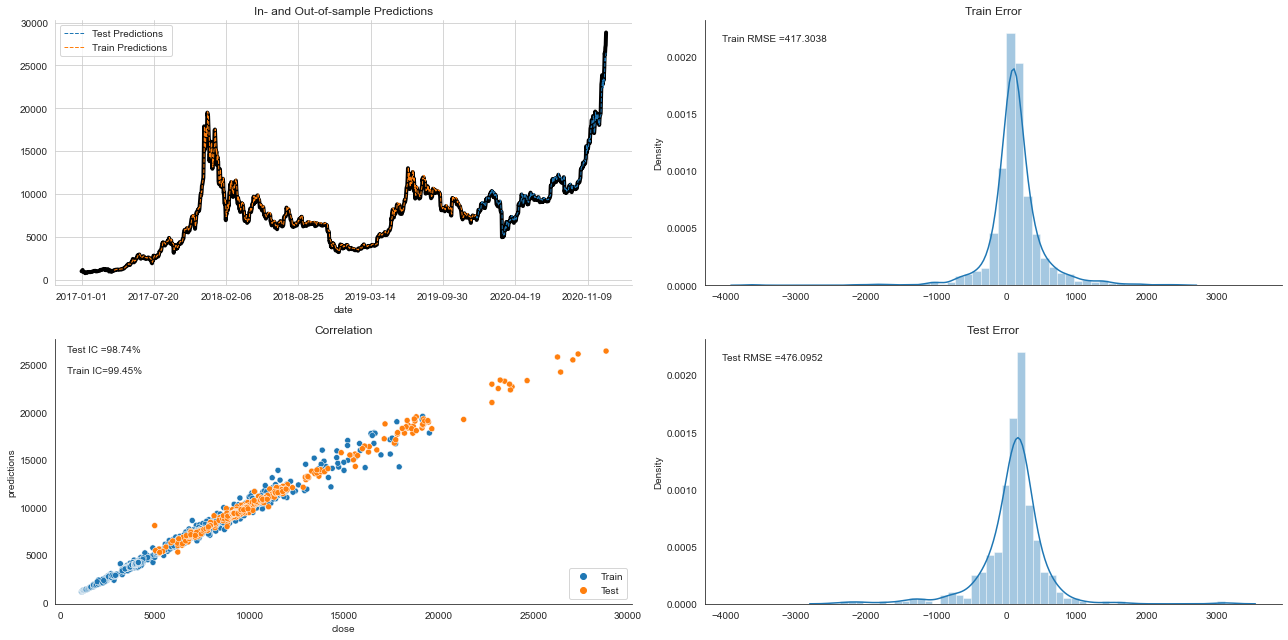

In [79]:
fig=plt.figure(figsize=(18,9))
ax1 = plt.subplot(221)

dfclose.loc['2017':, 'close'].plot(lw=4, ax=ax1, c='k')
dfclose.loc['2017':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')


with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='close', y='predictions', data=dfclose, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
# fig.savefig(results_path / 'rnn_cc_regression', dpi=300);

In [80]:
model_test = dfclose.copy()
ar = np.log(model_test['close']/model_test['close'].shift()).fillna(0)
pr = np.log(model_test['predictions'] / model_test['close'].shift()).fillna(0)
tmp = ar*pr[-30:]
accuracy = len(tmp[tmp>0])/30
print(f'Test accuracy: {accuracy:.2f}')

Test accuracy: 0.33


# Predicting Future Returns:

# Preprocessing

In [81]:
scaler = MinMaxScaler()
dfreturn_scaled = pd.Series(scaler.fit_transform(dfreturn).squeeze(),index =dfreturn.index)
dfreturn_scaled.describe()

count    1451.000000
mean        0.677030
std         0.061676
min         0.000000
25%         0.653182
50%         0.677319
75%         0.703472
max         1.000000
dtype: float64

# Generating recurrent sequences from the time series

In [82]:
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

In [83]:
window_size = 90

In [84]:
X,y = create_univariate_rnn_data(dfreturn_scaled, window_size)

In [85]:
X.shape

(1361, 90)

# Train-test split

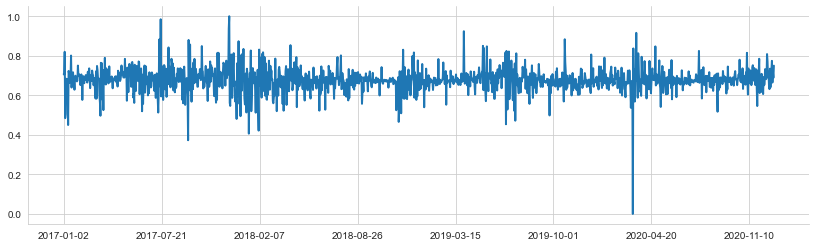

In [86]:
ax = dfreturn_scaled.plot(lw=2, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [87]:
X_train = X[:'2020'].values.reshape(-1, window_size, 1)
y_train = y[:'2020']

# keep the last year for testing
X_test = X['2020':].values.reshape(-1, window_size, 1)
y_test = y['2020':]

In [88]:
n_obs, window_size, n_features = X_train.shape

In [89]:
y_train.shape

(1001,)

# Define Model Architechture

In [90]:
rnn_return = Sequential([
    LSTM(units = 10, input_shape = (window_size,n_features), name='LSTM'),
    Dense(1, name='Output')
])

In [91]:
rnn_return.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (None, 10)                480       
_________________________________________________________________
Output (Dense)               (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


# Train the Model

In [92]:
rnn_return.compile(loss = 'mean_squared_error', optimizer = optimizer)

In [93]:
lstm_training_return = rnn_return.fit(X_train,y_train, epochs = 150, batch_size = 20, shuffle = True, validation_data=(X_test,y_test),callbacks = [early_stopping,checkpointer],verbose =1)

Epoch 1/150
51/51 [==============================] - 3s 18ms/step - loss: 0.7688 - val_loss: 0.0154

Epoch 00001: val_loss did not improve from 0.00029
Epoch 2/150
51/51 [==============================] - 1s 10ms/step - loss: 0.0063 - val_loss: 0.0038

Epoch 00002: val_loss did not improve from 0.00029
Epoch 3/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0045 - val_loss: 0.0111

Epoch 00003: val_loss did not improve from 0.00029
Epoch 4/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0051 - val_loss: 0.0035

Epoch 00004: val_loss did not improve from 0.00029
Epoch 5/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0054

Epoch 00005: val_loss did not improve from 0.00029
Epoch 6/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0045 - val_loss: 0.0035

Epoch 00006: val_loss did not improve from 0.00029
Epoch 7/150
51/51 [==============================] - 1s 10ms/step - loss: 0.0040 - val_l


Epoch 00054: val_loss did not improve from 0.00029
Epoch 55/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0042 - val_loss: 0.0038

Epoch 00055: val_loss did not improve from 0.00029
Epoch 56/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0041 - val_loss: 0.0034

Epoch 00056: val_loss did not improve from 0.00029
Epoch 57/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0042 - val_loss: 0.0045

Epoch 00057: val_loss did not improve from 0.00029
Epoch 58/150
51/51 [==============================] - 1s 10ms/step - loss: 0.0042 - val_loss: 0.0054

Epoch 00058: val_loss did not improve from 0.00029
Epoch 59/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0039 - val_loss: 0.0038

Epoch 00059: val_loss did not improve from 0.00029
Epoch 60/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0037 - val_loss: 0.0065

Epoch 00060: val_loss did not improve from 0.00029
Epoch 61/150
51/51 [==========

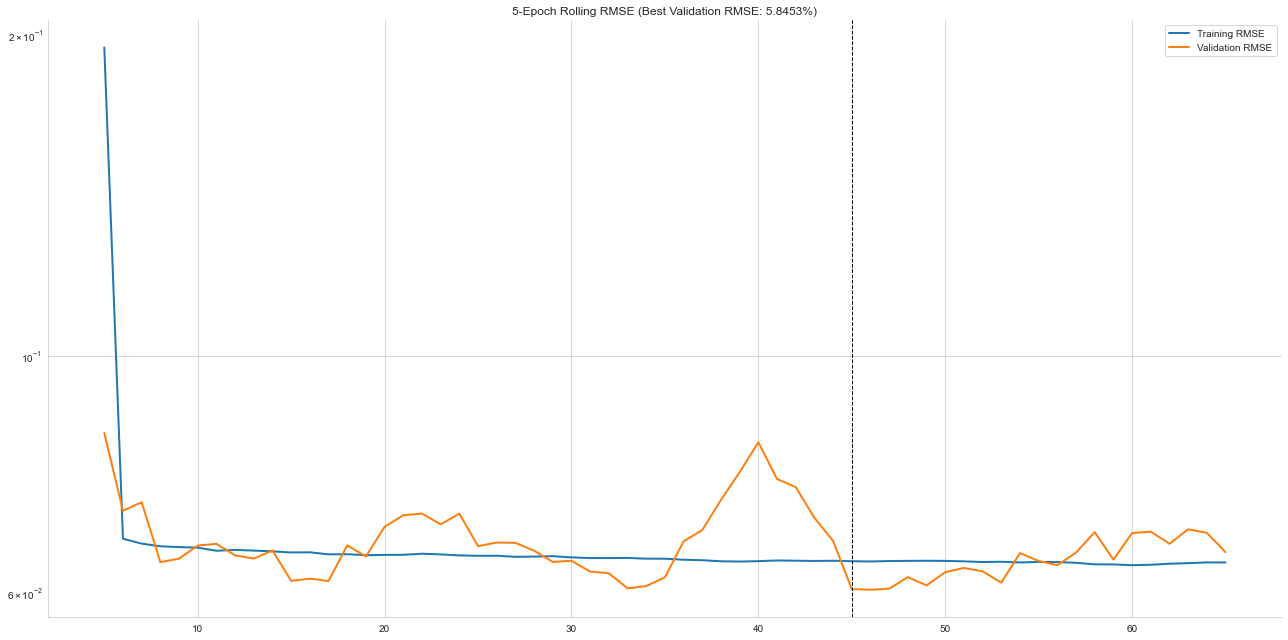

In [94]:
fig, ax = plt.subplots(figsize=(18, 9))

loss_history = pd.DataFrame(lstm_training_return.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_cc_error', dpi=300);

In [95]:
train_rmse_scaled = np.sqrt(rnn_return.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn_return.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

Train RMSE: 0.0628 | Test RMSE: 0.0585


In [96]:
train_predict_scaled = rnn_return.predict(X_train)
test_predict_scaled = rnn_return.predict(X_test)

In [97]:
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

Train IC: -0.0315 | Test IC: 0.0755


# Rescale predictions

In [98]:
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled).squeeze(), index=y_test.index))

In [99]:
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

In [100]:
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}'

'Train RMSE: 0.04 | Test RMSE: 0.04'

In [101]:
dfreturn['Train Predictions'] = train_predict
dfreturn['Test Predictions'] = test_predict
dfreturn = dfreturn.join(train_predict.to_frame('predictions').assign(data='Train')
                        .append(test_predict.to_frame('predictions').assign(data='Test')))

In [102]:
dfreturn

,return,Train Predictions,Test Predictions,predictions,data
date,,,,,
2017-01-02,0.023193,NaN,NaN,NaN,NaN
2017-01-03,0.021389,NaN,NaN,NaN,NaN
2017-01-04,0.100960,NaN,NaN,NaN,NaN
2017-01-05,-0.130575,NaN,NaN,NaN,NaN
2017-01-06,-0.116209,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2020-12-26,0.069389,NaN,0.004434,0.004434,Test
2020-12-27,-0.006251,NaN,0.003793,0.003793,Test
2020-12-28,0.030458,NaN,0.004286,0.004286,Test


In [103]:
model_test = dfreturn.copy().fillna(0)
tmp = model_test['return']*model_test['predictions'][-30:]
accuracy = len(tmp[tmp>0])/30
print(f'Test accuracy: {accuracy:.2f}')

Test accuracy: 0.67
